In [1]:
import os
import subprocess
import sys
import numpy as np
from IPython.display import display, HTML

In [2]:
top_level_dir = '/'.join( os.getcwd().split( '/' )[ :-2 ] )
if top_level_dir not in sys.path:
    sys.path.append( top_level_dir )

In [3]:
from GenModels.GM.States.GraphicalMessagePassing.Graph import Graph
from GenModels.GM.States.GraphicalMessagePassing.GraphicalMessagePassingBase import GraphMessagePasser, \
                                                                                    GraphMessagePasserFBS

# Graph without any cycles

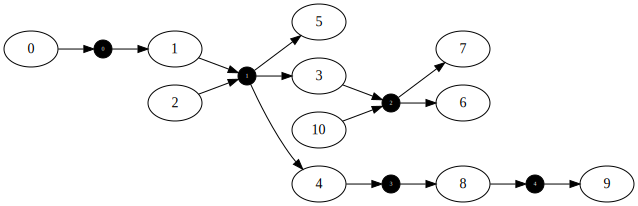

In [4]:
graph = Graph()
graph.addEdge( parents=[ 0 ], children=[ 1 ] )
graph.addEdge( parents=[ 1, 2 ], children=[ 3, 4, 5 ] )
graph.addEdge( parents=[ 3, 10 ], children=[ 6, 7 ] )
graph.addEdge( parents=[ 4 ], children=[ 8 ] )
graph.addEdge( parents=[ 8 ], children=[ 9 ] )
graph.draw( horizontal=True )

#### GraphMessagePasser will determine what order to visit the nodes

In [5]:
msg = GraphMessagePasser()
msg.updateParamsFromGraphs( [ graph ] )

In [6]:
# Path to tmp folder where the intermediate images will be rendered
tmp_folder = top_level_dir + '/GenModels/tmp'

# Some graphviz styles to color code the graph
selected_style = dict( fontcolor='black',
                       style='bold',
                       color='blue' )
styles = { 0: selected_style }

#### The AnimatorForwardPass class will keep track of the order of nodes that msg gives it

In [7]:
class AnimatorForwardPass():
    
    def __init__( self, msg ):
        self.msg = msg
        self.count = 0

    def __call__( self, node_list ):
        # For each node, mark that they should be drawn with selected_style
        node_to_style_key = dict( [ ( n, 0 ) for n in node_list ] )
        
        output_name = 'graph_%d'%( self.count )
        self.count += 1
        
        # Draw and save the graph for this iteration in tmp_folder
        self.msg.toGraph().draw( styles=styles, 
                                 horizontal=True, 
                                 node_to_style_key=node_to_style_key, 
                                 output_folder=tmp_folder,
                                 output_name=output_name )
        
animator = AnimatorForwardPass( msg )

#### Run a forward pass on graph

In [8]:
msg.forwardPass( animator )

#### Use the generated images to create and display a gif

In [9]:
# Convert the images to a gif using ImageMagick
image_paths = [ tmp_folder + '/graph_%d.png'%( j ) for j in range( animator.count ) ]
commands = [ 'convert', '-loop', '0', '-delay', '50' ] + image_paths + [ 'no_cycle_forward_pass.gif' ]
subprocess.call( commands )

# Delete the contents of tmp
subprocess.call( [ 'rm' ] + image_paths )

# Display the gif
HTML( '<img src="./%s">'%( 'no_cycle_forward_pass.gif' ) )

## Next, animate the up-down algorithm.  This is the algorithm used for filtering and smoothing in graphical latent state space models

In [10]:
# Use new styles
u_style = dict( fontcolor='black',
                style='bold',
                color='blue' )
v_style = dict( fontcolor='black',
                style='bold',
                color='green' )
edge_style = dict( fixedsize='true',
                   color='green' )
styles = { 0: u_style, 1: v_style, 2: edge_style }

In [11]:
class AnimatorUpDown():
    
    def __init__( self, msg ):
        self.count = 0
        self.current_nodes = []
        self.msg = msg
        
    def uWork( self, is_base_case, node_list ):
        self.current_nodes = node_list
        
    def vWork( self, is_base_case, node_and_edge_list ):
        
        # Update the style for the u and v list nodes
        node_to_style_key = dict( [ ( n, 0 ) for n in self.current_nodes ] )
        node_to_style_key.update( dict( [ ( n, 1 ) for n in  node_and_edge_list[ 0 ] ] ) )

        # Update the style for the v list edges
        edge_to_style_key = dict( [ ( ( n, e ), 2 ) for n, e in zip( *node_and_edge_list ) if e is not None ] )
        
        output_name = 'graph_%d'%( self.count )
        self.count += 1
        
        # Draw the graph
        self.msg.toGraph().draw( styles=styles, 
                                 horizontal=True, 
                                 node_to_style_key=node_to_style_key, 
                                 edge_to_style_key=edge_to_style_key, 
                                 output_folder=tmp_folder, 
                                 output_name=output_name )

animator = AnimatorUpDown( msg )

#### Similar to the forward backward algorithm and forward and backward kalman filter algorithms, the up-down algorithm does two different computations - u and v

In [12]:
msg.upDown( animator.uWork, animator.vWork )

#### Create the final gif

In [13]:
# Convert the images to a gif using ImageMagick
image_paths = [ tmp_folder + '/graph_%d.png'%( j ) for j in range( animator.count ) ]
commands = [ 'convert', '-loop', '0', '-delay', '50' ] + image_paths + [ 'no_cycle_up_down.gif' ]
subprocess.call( commands )

# Delete the contents of tmp
subprocess.call( [ 'rm' ] + image_paths )

# Display the gif
HTML( '<img src="./%s">'%( 'no_cycle_up_down.gif' ) )

# Now for a graph that has directed cycles and a feedback vertex set is known

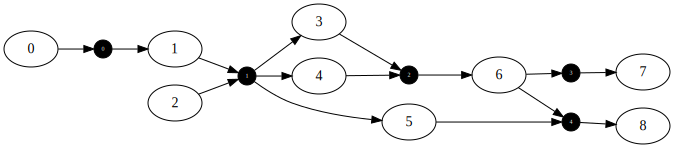

In [14]:
graph_cycles = Graph()
graph_cycles.addEdge( parents=[ 0 ], children=[ 1 ] )
graph_cycles.addEdge( parents=[ 1, 2 ], children=[ 3, 4, 5 ] )
graph_cycles.addEdge( parents=[ 3, 4 ], children=[ 6 ] )
graph_cycles.addEdge( parents=[ 6 ], children=[ 7 ] )
graph_cycles.addEdge( parents=[ 5, 6 ], children=[ 8 ] )

feedback_set = np.array( [ 3, 5 ] )
graph_cycles.draw( horizontal=True )

#### The GraphMessagePasserFBS class will be able to run the up-down algorithm using the feedback set method

In [15]:
msg = GraphMessagePasserFBS()
msg.updateParamsFromGraphs( [ ( graph_cycles, feedback_set ) ] )

#### Add a new style for the fbs and update the animator to show fbs nodes

In [16]:
u_style = dict( fontcolor='black',
                style='bold',
                color='blue' )
v_style = dict( fontcolor='black',
                style='bold',
                color='green' )
edge_style = dict( fixedsize='true',
                   color='green' )
fbs_node_style = dict( fontcolor='black',
                       style='filled',
                       color='red' )
styles = { 0: u_style, 1: v_style, 2: edge_style, 3:fbs_node_style }

In [17]:
class AnimatorUpDownFBS():
    
    def __init__( self, msg ):
        self.count = 0
        self.current_nodes = []
        self.msg = msg
        
    def uWork( self, is_base_case, node_list ):
        self.current_nodes = node_list
        
    def vWork( self, is_base_case, node_and_edge_list ):
        
        # Update the style for the fbs, u list and vlist nodes
        node_to_style_key = dict( [ ( n, 3 ) for n in msg.fbs ] )
        node_to_style_key.update( dict( [ ( int( msg.partialGraphIndexToFullGraphIndex( n ) ), 0 ) for n in self.current_nodes ] ) )
        node_to_style_key.update( dict( [ ( int( msg.partialGraphIndexToFullGraphIndex( n ) ), 1 ) for n in  node_and_edge_list[ 0 ] ] ) )

        # Update the style for the v list edges
        edge_to_style_key = dict( [ ( ( int( msg.partialGraphIndexToFullGraphIndex( n ) ), e ), 2 ) for n, e in zip( *node_and_edge_list ) if e is not None ] )

        output_name = 'graph_%d'%( self.count )
        self.count += 1
        
        # Draw the graph
        self.msg.toGraph().draw( styles=styles, 
                                 horizontal=True, 
                                 node_to_style_key=node_to_style_key, 
                                 edge_to_style_key=edge_to_style_key, 
                                 output_folder=tmp_folder, 
                                 output_name=output_name )

animator = AnimatorUpDownFBS( msg )

In [18]:
msg.upDown( animator.uWork, animator.vWork )

# The u steps are blue, v steps are green and fbs nodes are red

In [19]:
# Convert the images to a gif using ImageMagick
image_paths = [ tmp_folder + '/graph_%d.png'%( j ) for j in range( animator.count ) ]
commands = [ 'convert', '-loop', '0', '-delay', '50' ] + image_paths + [ 'cycle_up_down.gif' ]
subprocess.call( commands )

# Delete the contents of tmp
subprocess.call( [ 'rm' ] + image_paths )

# Display the gif
HTML( '<img src="./%s">'%( 'cycle_up_down.gif' ) )

# A loopy belief propagation example

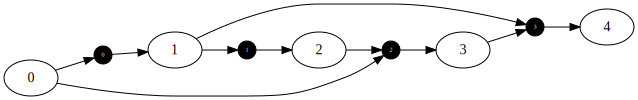

In [27]:
graph_loopy_cycles = Graph()
graph_loopy_cycles.addEdge( parents=[ 0 ], children=[ 1 ] )
graph_loopy_cycles.addEdge( parents=[ 1 ], children=[ 2 ] )
graph_loopy_cycles.addEdge( parents=[ 0, 2 ], children=[ 3 ] )
graph_loopy_cycles.addEdge( parents=[ 1, 3 ], children=[ 4 ] )

feedback_set = np.array( [] )
graph_loopy_cycles.draw( horizontal=True )

In [34]:
class AnimatorUpDownLoopy():
    
    def __init__( self, msg ):
        self.count = 0
        self.current_nodes = []
        self.msg = msg
        
    def uWork( self, is_base_case, node_list ):
        self.current_nodes = node_list
        
    def vWork( self, is_base_case, node_and_edge_list ):
        
        # Update the style for the u and v list nodes
        node_to_style_key = dict( [ ( n, 0 ) for n in self.current_nodes ] )
        node_to_style_key.update( dict( [ ( n, 1 ) for n in  node_and_edge_list[ 0 ] ] ) )

        # Update the style for the v list edges
        edge_to_style_key = dict( [ ( ( n, e ), 2 ) for n, e in zip( *node_and_edge_list ) if e is not None ] )
        
        output_name = 'graph_%d'%( self.count )
        self.count += 1
        
        # Draw the graph
        self.msg.toGraph().draw( styles=styles, 
                                 horizontal=True, 
                                 node_to_style_key=node_to_style_key, 
                                 edge_to_style_key=edge_to_style_key, 
                                 output_folder=tmp_folder, 
                                 output_name=output_name )
        
    def loopyHasConverged( self ):
        return self.count > 6

msg.updateParamsFromGraphs( [ ( graph_loopy_cycles, feedback_set ) ] )
animator = AnimatorUpDownLoopy( msg )

In [35]:
msg.upDown( animator.uWork, animator.vWork, loopyHasConverged=animator.loopyHasConverged )

Cycle encountered!  Starting loopy belief propogation...
u_list [0]
v_list [[4], [None]]
u_list [1 3]
v_list (array([2]), array([2]))
u_list [2 4]
v_list (array([1, 3, 1]), array([3, 3, 1]))
u_list [2 3 4]
v_list (array([2, 0, 0, 3]), array([2, 0, 2, 3]))
u_list [1 3 4]
v_list (array([1, 1, 0, 2]), array([3, 1, 2, 2]))
u_list [1 2 4]
v_list (array([1, 3, 0, 1]), array([3, 3, 0, 1]))


In [36]:
# Convert the images to a gif using ImageMagick
image_paths = [ tmp_folder + '/graph_%d.png'%( j ) for j in range( animator.count ) ]
commands = [ 'convert', '-loop', '0', '-delay', '50' ] + image_paths + [ 'cycle_up_down_loopy.gif' ]
subprocess.call( commands )

# Delete the contents of tmp
subprocess.call( [ 'rm' ] + image_paths )

# Display the gif
HTML( '<img src="./%s">'%( 'cycle_up_down_loopy.gif' ) )